In [2]:
# importando as bibliotecas 

import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import zipfile as zp
import io
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap 
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

# importando arquivos 
# URL do arquivo ZIP para mapa coroplético
url = "http://www.usp.br/nereus/wp-content/uploads/BR_UF_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
response = rq.get(url)
zip_file = zp.ZipFile(io.BytesIO(response.content))
zip_file.extractall("/content/brasil_estados_folder")

# Importar o shapefile
brasil_estados = gpd.read_file("/content/brasil_estados_folder/BR_UF_2021.shp")

# importando o DataSet anp meses 5 e 6

gas_eta_5=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-05.csv' ,sep=';')
gas_eta_6=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-06.csv',sep=';')
gas_eta=pd.concat([gas_eta_5,gas_eta_6])

# estados da união 
estados = {"AC": "Acre","AL": "Alagoas","AP": "Amapá","AM": "Amazonas","BA": "Bahia","CE": "Ceará","DF": "Distrito Federal","ES": "Espírito Santo","GO": "Goiás","MA": "Maranhão","MT": "Mato Grosso","MS": "Mato Grosso do Sul","MG": "Minas Gerais","PA": "Pará","PB": "Paraíba","PR": "Paraná","PE": "Pernambuco","PI": "Piauí","RJ": "Rio de Janeiro","RN": "Rio Grande do Norte","RS": "Rio Grande do Sul","RO": "Rondônia","RR": "Roraima","SC": "Santa Catarina","SP": "São Paulo","SE": "Sergipe","TO": "Tocantins"}

# regiões
siglas_para_regioes = {
    'SE':'Sudeste',
    'S' :'Sul',
    'N' : 'Norte',
    'NE': 'Nordeste',
    'CO': 'Centro\noeste'
}

# retirando colunas que não serão utilizadas do DataSet

gas_eta=pd.DataFrame(gas_eta,columns=['Regiao - Sigla','Estado - Sigla','Municipio','Produto','Data da Coleta','Valor de Venda','Bandeira'])

# transformando os dados da coluna valor da venda para float
gas_eta['Valor de Venda']=gas_eta['Valor de Venda'].apply(lambda x: float(x.replace(',','.')))

# transformando os dados de data para datetime
gas_eta['Data da Coleta']=pd.to_datetime(gas_eta['Data da Coleta'],dayfirst=True)

# trocando o nome de siglas para o nome dos estados 
gas_eta['Estado - Sigla']=gas_eta['Estado - Sigla'].apply(lambda x:estados[x])

# trocando o nome das siglas das regiões para o nome das regiões
gas_eta['Regiao - Sigla']=gas_eta['Regiao - Sigla'].apply(lambda x:siglas_para_regioes[x])

# manipulando o nome dos municipios
gas_eta['Municipio']=gas_eta['Municipio'].apply(lambda x:x.replace(' ','\n'))

# trocando o nome das colunas em quê o valor foi alterado
gas_eta.rename(columns={'Estado - Sigla':'Estado','Regiao - Sigla':'Regiao'},inplace=True)


# criando o dataframe com o dado mdc=media diaria dos preços combustiveis 

# nesse dataframe tranformamos os valores da coluna produtos em colunas é as data em indices
# além disso acrescentamos as datas em que não foram feitas coletas utilizando o metodo nearest
# para que fosse atribuido a essas linhas o valor de indice mais proximo 
mdc=gas_eta.pivot_table(columns='Produto',index='Data da Coleta',values='Valor de Venda', aggfunc='mean').reindex(pd.date_range(start='2023-05-01',end='2023-06-30'),method='nearest')

# media no valor do combustivel nos ultimos dois meses 

media_combustivel=mdc.mean()

# media do valor por estado 

media_por_estado=gas_eta.pivot_table(columns='Produto',index='Estado',values='Valor de Venda', aggfunc='mean')

# dicionario com os estados com maior valor de combustiveis por estado

dic_combustives_estado={'GASOLINA_ADITIVADA':media_por_estado['GASOLINA ADITIVADA'].sort_values(ascending=False)[:5],
'GASOLINA':media_por_estado['GASOLINA'].sort_values(ascending=False)[:5],
'ETANOL':media_por_estado['ETANOL'].sort_values(ascending=False)[:5]
}
#media municipal
media_municipal=gas_eta.pivot_table(columns='Produto',index='Municipio',values='Valor de Venda', aggfunc='mean')

# dicionarios com os municipios com maior valor de combustivel 
 
municipios_mais_caros={'GASOLINA':media_municipal['GASOLINA'].sort_values(ascending=False)[:5],
'GASOLINA ADITIVADA':media_municipal['GASOLINA ADITIVADA'].sort_values(ascending=False)[:5],
'ETANOL':media_municipal['ETANOL'].sort_values(ascending=False)[:5]}

# dicionario com os municipios  mais baratos 

municipios_mais_baratos={'GASOLINA':media_municipal['GASOLINA'].sort_values()[:5],
'GASOLINA ADITIVADA':media_municipal['GASOLINA ADITIVADA'].sort_values()[:5],
'ETANOL':media_municipal['ETANOL'].sort_values()[:5]}

# media no valor dos combustiveis

preco_por_regiao=gas_eta.pivot_table(columns='Regiao',index='Produto',values='Valor de Venda', aggfunc='mean')

# media por data e produto, dividido por região 

media_regiao_data=gas_eta.pivot_table(columns='Regiao',values='Valor de Venda',index=['Produto','Data da Coleta'],aggfunc='mean').dropna()

  



In [46]:
# essa função é responsavel por tirar o percentual dos quatro maiores integrantes de uma Series de dados e somar os demais.
def media_5(quantidade_item,nome_extra):
    percentual=(quantidade_item/quantidade_item.sum())*100
    quatro_maiores=percentual[:4]
    quatro_maiores[nome_extra]=percentual[4:].sum()
    return quatro_maiores

maiores_media=media_5(gas_eta['Bandeira'][gas_eta['Produto']=='GASOLINA'].value_counts(),'Outras Bandeiras')

In [75]:
media_combustiveis=gas_eta.pivot_table(columns='Bandeira',index=['Produto','Data da Coleta'],values='Valor de Venda', aggfunc='mean')

In [68]:
# filtra os itens especificados no atributo e tira uma media dos demais
def escolher_item(itens,itens_filtro,demais_itens):
    itens_f=itens[itens_filtro]
    itens_f[demais_itens]=itens.drop(itens_filtro).mean()
    return itens_f.sort_values()


escolher_item(media_combustiveis.loc['GASOLINA'].mean(),maiores_media[:4].index,maiores_media[4:].index[0])



BRANCA              5.296841
RAIZEN              5.399211
Outras Bandeiras    5.426917
IPIRANGA            5.459004
VIBRA ENERGIA       5.476278
dtype: float64

In [85]:
media_diaria_b=media_combustiveis[maiores_media[:4].index].copy()
media_diaria_b[maiores_media[4:].index[0]]=media_combustiveis.drop(columns=maiores_media[:4].index).T.mean()


Bandeira                             BRANCA  VIBRA ENERGIA  IPIRANGA  \
Produto            Data da Coleta                                      
ETANOL             2023-05-01      4.178765       4.371296  4.283476   
                   2023-05-02      4.204272       4.420364  4.344125   
                   2023-05-03      4.220052       4.436731  4.386239   
                   2023-05-04      4.161204       4.348120  4.323043   
                   2023-05-05      4.166667       4.437586  4.302326   
...                                     ...            ...       ...   
GASOLINA ADITIVADA 2023-06-26      5.354143       5.613608  5.582291   
                   2023-06-27      5.405370       5.609268  5.616066   
                   2023-06-28      5.367752       5.616101  5.618128   
                   2023-06-29      5.452260       5.648037  5.698561   
                   2023-06-30      5.658333       5.736000  5.785000   

Bandeira                             RAIZEN  Outras Bandeiras  
Produto            Data da Coleta                              
ETANOL             2023-05-01      4.262406          4.507326  
                   2023-05-02      4.329779          4.507206  
                   2023-05-03      4.366500          4.532789  
                   2023-05-04      4.271809          4.409702  
                   2023-05-05      4.158846          4.047245  
...                                     ...               ...  
GASOLINA ADITIVADA 2023-06-26      5.643779          5.548325  
                   2023-06-27      5.603273          5.567674  
                   2023-06-28      5.674632          5.632495  
                   2023-06-29      5.767600          5.642957  
                   2023-06-30      5.676667          5.780000  

[135 rows x 5 columns]

In [91]:
media_diaria_b.loc['GASOLINA'].corr()

Bandeira,BRANCA,VIBRA ENERGIA,IPIRANGA,RAIZEN,Outras Bandeiras
Bandeira,,,,,
BRANCA,1.000000,0.867852,0.807978,0.785329,0.535288
VIBRA ENERGIA,0.867852,1.000000,0.861174,0.705217,0.629878
IPIRANGA,0.807978,0.861174,1.000000,0.723307,0.649615
RAIZEN,0.785329,0.705217,0.723307,1.000000,0.404042
Outras Bandeiras,0.535288,0.629878,0.649615,0.404042,1.000000


In [95]:
def rotulacao(ax, bars,s1='R$',s2='',altura=0.4):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{s1}{height:.2f}{s2}'.replace('.',','),xy=(bar.get_x() + bar.get_width() / 2, height-altura),xytext=(0, 3),textcoords="offset points",ha='center', va='bottom',color='white',fontsize=12,fontstyle= 'italic',fontweight= 'bold')


In [96]:
def adicionar_rotulos(obj,barras,font=15):
    for barra in barras:
        largura = barra.get_width()
        obj.text(largura-0.5, barra.get_y() + barra.get_height() / 2, f'R${largura:.2f}'.replace('.',','), ha='right', va='center', color='white', fontweight='bold',fontsize=font)


In [104]:
def grafico_correlacao(cor,titulo,item):

    maiores_media=media_5(gas_eta['Bandeira'][gas_eta['Produto']==item].value_counts(),'Outras Bandeiras')
    media_combustiveis=gas_eta.pivot_table(columns='Bandeira',index=['Produto','Data da Coleta'],values='Valor de Venda', aggfunc='mean')
    media_diaria_b=media_combustiveis[maiores_media[:4].index].copy()
    media_diaria_b[maiores_media[4:].index[0]]=media_combustiveis.drop(columns=maiores_media[:4].index).T.mean()
    media_valor=escolher_item(media_combustiveis.loc[item].mean(),maiores_media[:4].index,maiores_media[4:].index[0])

    fig=plt.figure(figsize=(20,7))
    g1=plt.subplot(131)
    g2=plt.subplot(132)
    g3=plt.subplot(133)

    rotulacao(g1,g1.bar(maiores_media.index,maiores_media.values,color=cor),s1='',s2='%',altura=2.8)
    g1.set_yticks([])
    g1.set_xticks(maiores_media.index,(i.replace(' ','\n')for i in maiores_media.index),color='grey',fontweight= 'bold',fontsize=12, fontstyle= 'italic')
    g1.spines[['top', 'right','left']].set_visible(False)
    g1.set_title(f'participação de mercado\n', fontsize=20, fontweight='bold', color=cor)


    adicionar_rotulos(g2,g2.barh(media_valor.index,media_valor.values,color=cor))
    g2.set_yticks(media_valor.index,media_valor.index,color='grey',fontweight= 'bold',fontsize=15, fontstyle= 'italic')
    g2.set_xticks([])
    g2.spines[['top', 'right','left']].set_visible(False)
    g2.set_title(f'preço medio das bandeiras\n', fontsize=20, fontweight='bold', color=cor)

    sns.heatmap(media_diaria_b.loc[item].corr(), annot=True, cmap=LinearSegmentedColormap.from_list('CustomColors',['white',cor]), center=0, linewidths=.5, cbar=False,ax=g3,annot_kws={"size": 15,'fontweight':'bold'})
    g3.set_xticklabels((i.replace(' ','\n')for i in media_diaria_b.loc[item].corr().index ), rotation=0,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')  # Rótulos do eixo X rotacionados em 45 graus
    g3.set_yticklabels((i.replace(' ','\n')for i in media_diaria_b.loc[item].corr().index ), rotation=0,color='grey',fontsize=12, fontweight='bold',fontstyle= 'italic')
    g3.set_title(f'correlação entre as bandeiras\n', fontsize=20, fontweight='bold', color=cor)
    g3.set_ylabel('') 
    g3.set_xlabel('') 

    fig.suptitle(titulo, fontsize=30, fontweight='bold', color=cor,fontstyle= 'italic', x=0.05, ha='left')
    plt.tight_layout(rect=[0, 0.10, 1, 0.9])
    plt.subplots_adjust(wspace=0.4) 



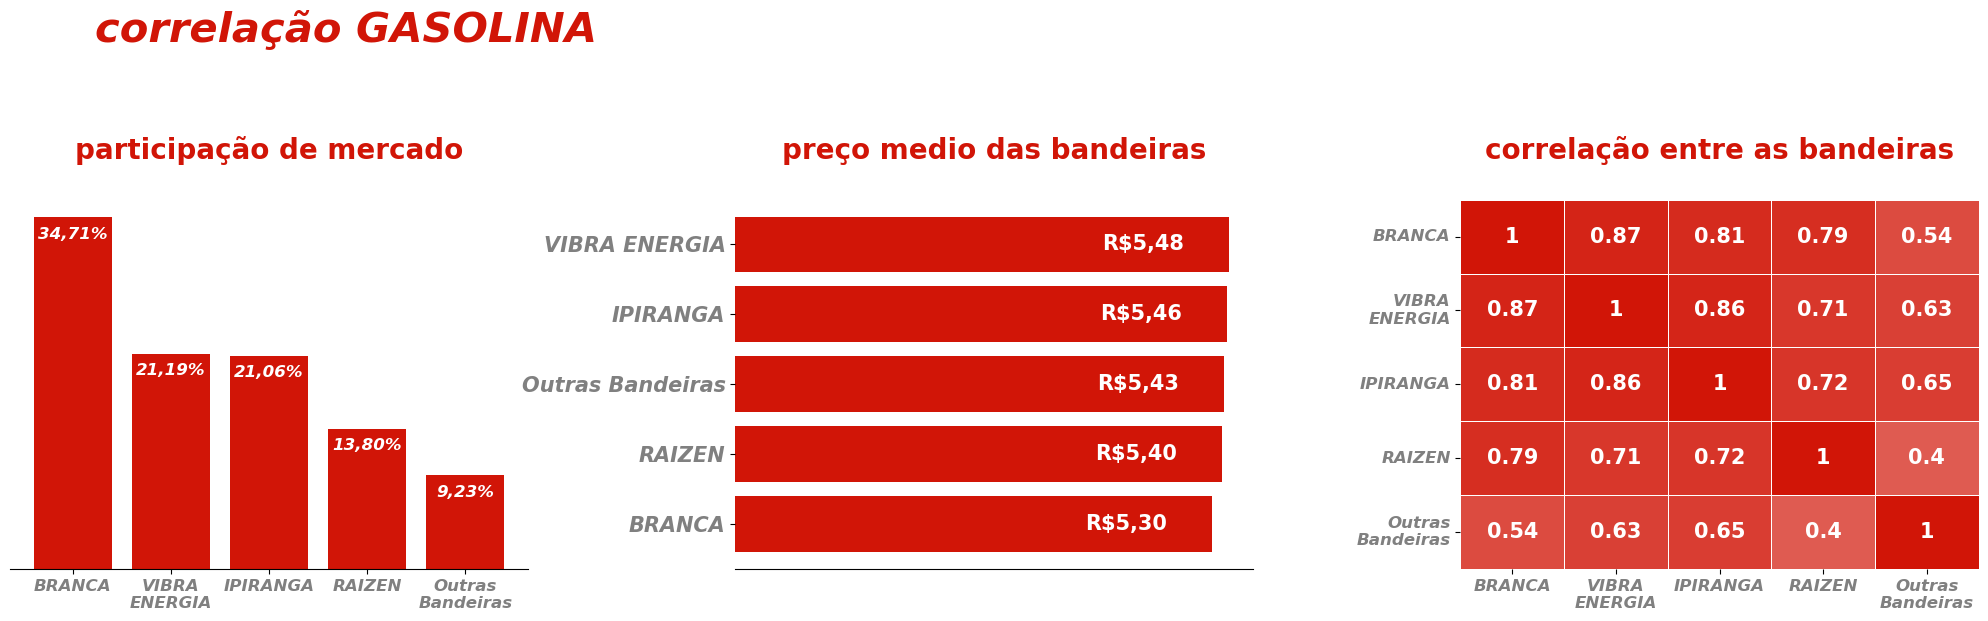

In [108]:
grafico_correlacao('#a51b0b','correlação GASOLINA','GASOLINA')

In [ ]:
#.apply(lambda x: f'{x:.2f} %'.replace('.',','))